# api setup

In [55]:
import getpass
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")
if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

In [56]:
# set up tavily search tool
from langchain_tavily import TavilySearch

search_tool = TavilySearch(
    max_results = 3,
    topic = "finance"
    )

In [ ]:
# set up llm
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model = "gpt-4o",
    temperature = .1,
    max_tokens = 5000,
    max_retries = 2,
)

In [ ]:
#prompt template
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

# nodes

In [ ]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent
from langgraph.graph import END, StateGraph, START, MessagesState
from langgraph.types import Command

class MessagesState(TypedDict):
    # append messages instead of replace
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        return END
    return goto

In [ ]:
# research node
research_agent = create_react_agent(
    model = llm,
    tools = [search_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
        "You should use your tool to search online for financial news to answer the prompt."
        "Make sure the news is from the past week. As recent as possible is preferable."
        "hen you receive search results, read them and return a bullet-point summary of key findings.\n"
        "Be specific, quote numbers, and include URLs. Don’t say 'you couldn't find anything' unless the result set is actually empty."
        "Support your advice with quantitative metrics like stock price percent changes, key ratios, and other relevant data."
    ),
)

def researcher(state: MessagesState) -> Command[Literal["generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "generator")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            "messages": result["messages"],
        },
        goto=goto,
    )



In [ ]:
# generation node
generator_agent = create_react_agent(
    model = llm,
    tools = [],
    prompt=make_system_prompt(
        "You are a market prediction assistant. You receive detailed research from your teammate.\n"
        "Use the information provided by the 'researcher' to make market predictions and analysis.\n"
        "Cite the research and justify your predictions based on it.\n" \
        "You don't have to be very concise. Make sure you are giving good information and evidence."
    ),
)

def generator(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = generator_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="generator"
    )
    return Command(
        update={
            "messages": result["messages"],
        },
        goto=goto,
    )


# define graph

In [ ]:
workflow = StateGraph(MessagesState)

workflow.add_node("researcher", researcher)
workflow.add_node("generator", generator)

workflow.add_edge(START, "researcher")
graph = workflow.compile()


# draw graph

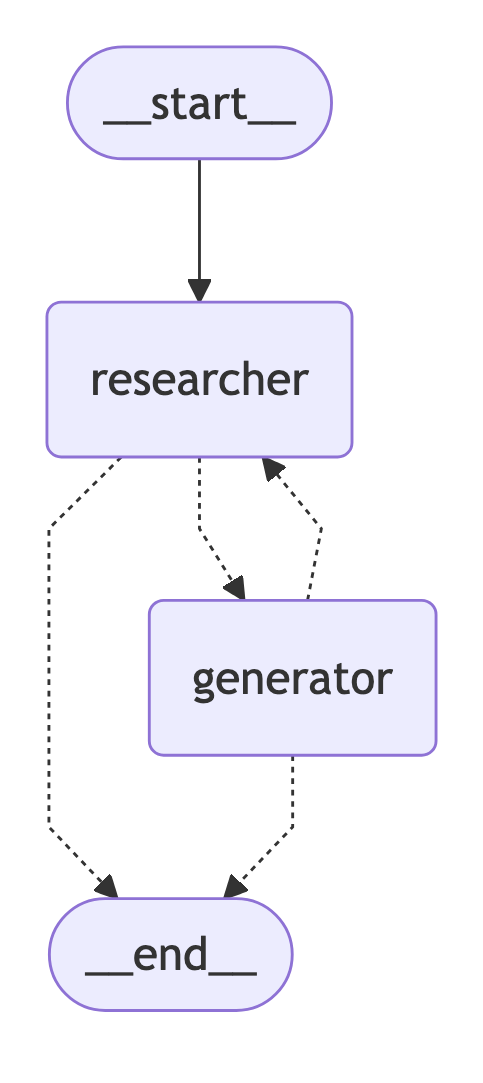

In [64]:
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from IPython.display import Image, display
import nest_asyncio
nest_asyncio.apply()

# Draw using Pyppeteer
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)




# execution

In [65]:
question = input("Ask a question about the market: ")

events = graph.stream(
    {
        "messages": [
            ("user", question)
        ],
    },
    {"recursion_limit": 20},
)

In [66]:
for event in events:
    if "generator" in event:
        messages = event["generator"].get("messages", [])
        for msg in messages:
            if "FINAL ANSWER:" in msg.content:
                final_answer = msg.content.split("FINAL ANSWER:")[-1].strip()
                print(final_answer)
    elif "researcher" in event:
        messages = event["researcher"].get("messages", [])
        for msg in messages:
            if "FINAL ANSWER:" in msg.content:
                final_answer = msg.content.split("FINAL ANSWER:")[-1].strip()
                print(final_answer)


The S&P 500 has recently experienced significant volatility but also notable gains. It rose by 2.5%, marking its best day since April 9, driven by optimism over easing trade tensions. However, it also saw a 2.2% decline on April 16, marking the 18th time this year it fell by at least 1% in a single session. Historically, such volatility has been followed by strong returns, averaging 28.3% in the following year. The index is currently up more than 2% following positive trade developments, though it remains sensitive to geopolitical changes. [Sources: Bloomberg, Yahoo Finance]
